In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from Resources.Model import Model_v4
from Resources.Game import *
from Resources.TS_ModelGuided import *
from Resources.TS_ModelGuided_MCRollout import *


##### Setup Model

In [61]:
model_1 = Model_v4()
model_1.eval()
model_1.load_state_dict(torch.load('../Train Value Function/Monte Carlo/Model Saves MC v4/model_51410_games'))

model_2 = Model_v4()
model_2.eval()
model_2.load_state_dict(torch.load('../Train Value Function/Monte Carlo/Model Saves MC v4/model_51410_games'))

# model2 = Model_v4()
# model2.eval()

<All keys matched successfully>

Settings

In [65]:
n_test_games = 100

# strategies = ['one step greedy', 'TS', 'TS with rollout']

strategy_1 = 'one step greedy'
strategy_2 = 'TS'

tmax_1 = 1 # seconds of tree search per move, if applies
tmax_2 = 10 # seconds of tree search per move, if applies

wins_1 = 0
wins_2 = 0
draws  = 0

In [13]:
for i_test_game in range(n_test_games): # loop through test games

    game = Game()
    i = 0

    color_choice = np.random.choice([True, False])

    if color_choice:
        color_1 = 'white'
        color_2 = 'black'
    else:
        color_1 = 'black'
        color_2 = 'white'

    value_list_1 = []
    value_list_2 = []

    while not game.is_over(): # loop through moves in current test game

        if game.turn == color_1:
            model_curr      = model_1
            strategy_curr   = strategy_1
            if 'TS' in strategy_curr:
                tmax_curr   = tmax_1
        else:
            model_curr      = model_2
            strategy_curr   = strategy_2
            if 'TS' in strategy_curr:
                tmax_curr   = tmax_2

        if strategy_curr == 'one step greedy':

            # play move that achieves highest value given current model
            # except: if a move checkmates, always chose that move

            moves = game.PossibleMoves()
            game_ini = game.copy()
            board_batch = []

            mate = False
            for move in moves:
                game.PlayMove(move)
                board_batch.append(board_to_tensor(game.pieces))
                game.FlipBoard()
                if game.is_over():
                    if game.get_winner() != 'draw':
                        mate = True
                        chosen_move = move
                        game = game_ini.copy()
                        break
                game = game_ini.copy()

            if not mate:
                
                board_tensor = torch.stack(board_batch)

                if i < 11: # in early phase of game, chose move stochastically to avoid repeating games
                    values = model_curr(board_tensor)
                    values_diff = [10*(values[i] - torch.mean(values)) for i in range(0, len(values))]
                    move_prob = torch.softmax(torch.Tensor(values_diff), dim=0).numpy()
                    chosen_i = np.random.choice(range(len(moves)), p=move_prob)
                    chosen_move = moves[chosen_i]

                else:
                    values = model_curr(board_tensor).detach().numpy()
                    chosen_move = moves[np.argmax(values)]

            if game.turn == color_1:
                value_list_1.append(max(values))
            if game.turn == color_2:
                value_list_2.append(max(values))

        elif strategy_curr == 'TS':

            chosen_move, root = ModelGuided_TS(game, model_curr, root=None, tmax=tmax_curr, prints=False)

        elif strategy_curr == 'TS with rollout':

            chosen_move, root = MC_TS(game, model_curr, root=None, tmax=tmax_curr, prints=False)

        game.PlayMove(chosen_move)
        game.FlipBoard()

        i += 1

    winner = game.get_winner()

    if winner == color_1:
        wins_1 += 1
        print('win 1')
    elif winner == color_2:
        wins_2 += 1
        print('win 2')
    elif winner == 'draw':
        draws += 1
        print('draw')

    print(' -- {} -- winner: {}'.format(i_test_game, winner))

print()
print('final statistics:')
print('wins 1: {}, draws: {}, wins 2: {}'.format(wins_1, draws, wins_2))


 -- 0 -- winner: white
 -- 1 -- winner: black
 -- 2 -- winner: black
 -- 3 -- winner: black
 -- 4 -- winner: black
 -- 5 -- winner: draw
 -- 6 -- winner: black
 -- 7 -- winner: white
 -- 8 -- winner: draw
 -- 9 -- winner: black
 -- 10 -- winner: black
 -- 11 -- winner: draw
 -- 12 -- winner: draw
 -- 13 -- winner: black
 -- 14 -- winner: black
 -- 15 -- winner: black
 -- 16 -- winner: white
 -- 17 -- winner: draw
 -- 18 -- winner: white
 -- 19 -- winner: black
 -- 20 -- winner: black
 -- 21 -- winner: draw
 -- 22 -- winner: black
 -- 23 -- winner: draw
 -- 24 -- winner: draw
 -- 25 -- winner: black
 -- 26 -- winner: black
 -- 27 -- winner: white
 -- 28 -- winner: black
 -- 29 -- winner: black
 -- 30 -- winner: draw
 -- 31 -- winner: white
 -- 32 -- winner: black
 -- 33 -- winner: black
 -- 34 -- winner: white
 -- 35 -- winner: black
 -- 36 -- winner: white
 -- 37 -- winner: black
 -- 38 -- winner: white
 -- 39 -- winner: draw
 -- 40 -- winner: draw
 -- 41 -- winner: white
 -- 42 -- win

In [ ]:
'''
MC (51410) one step greedy  vs  MC (51410) one step greedy
    wins 1: 312, draws: 420, wins 2: 303

MC (51410) one step greedy  vs  untrained one step greedy
    wins 1: 828, draws: 113, wins 2: 59

'''

In [ ]:
model(board_to_tensor(board)).detach().numpy()

In [85]:
board_batch = []

game = Game()
test_board = np.array([[14,  0,  0, 16,  0,  0,  0, 14],
       [ 0, 11, 11,  0,  0, 11, 11, 11],
       [ 0,  0,  0, 15, 13, 12,  0,  0],
       [11,  0,  0, 11,  0,  0,  0,  0],
       [ 0,  0,  0, 12, 11,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  1,  1],
       [ 1,  0,  1,  1,  1,  1,  3,  0],
       [ 4,  2,  0,  0,  6,  5,  2,  4]], dtype='uint8')
game.pieces = test_board.copy()
# game.FlipBoard()
# board_batch.append(board_to_tensor(game.pieces))
# game.FlipBoard()
# game.PlayMove(((6, 4), (5, 4), 'pawn'))
# game.FlipBoard()
# game.PlayMove(((3, 4), (1, 5), 'knight'))
# board_batch.append(board_to_tensor(game.pieces))
# game.FlipBoard()
# game.PlayMove(((7, 4), (7, 3), 'king'))
# game.FlipBoard()
# game.PlayMove(((1, 5), (0, 7), 'knight'))
# board_batch.append(board_to_tensor(game.pieces))
# game.FlipBoard()
# print(game.pieces)
# print(model_1(torch.stack([board_to_tensor(game.pieces)])).detach().numpy())
# game.PlayMove(((6, 6), (4, 4), 'bishop'))
# print(game.pieces)
# print(model_1(torch.stack([board_to_tensor(game.pieces)])).detach().numpy())

array([[-0.14085473]], dtype=float32)

In [64]:
values =  model_1(torch.stack(board_batch)).detach().numpy()
print(values)

[[ 0.09627875]
 [-0.02825887]
 [ 0.06133867]]


In [30]:
moves = game.PossibleMoves()
game_ini = game.copy()
board_batch = []
mate = False
for move in moves:
    game.PlayMove(move)
    board_batch.append(board_to_tensor(game.pieces))
    game.FlipBoard()
    if game.is_over():
        if game.get_winner() != 'draw':
            mate = True
            chosen_move = move
            game = game_ini.copy()
            break
    game = game_ini.copy()
if not mate:
    board_tensor = torch.stack(board_batch)
    values = model_curr(board_tensor).detach().numpy()
    chosen_move = moves[np.argmax(values)]

print(chosen_move)

((5, 4), (3, 6), 'queen')


In [103]:
chosen_move, root = ModelGuided_TS(game, model_1, root=None, batches=60, tmax=30, prints=False, factor_explore=1e-1)

In [104]:
chosen_move

((6, 4), (5, 4), 'pawn')

In [106]:
print(root.visits)

# for c, child in enumerate(root.children):

print()
for c, child in enumerate(root.children):
    print(child.move, child.visits, root.values_value_sum[c])
    if child.move == ((6, 4), (5, 4), 'pawn'):
        next_root = child
        break

for c, child in enumerate(next_root.children):
    print(child.move, child.visits, next_root.values_value_sum[c])
    # if child.move == ((6, 6), (4, 4), 'bishop'):
    #     next_root = child
    #     break



28391

((7, 4), (7, 3), 'king') 524 [-0.19186603]
((6, 0), (4, 0), 'pawn double') 129 [-0.20647992]
((6, 5), (4, 5), 'pawn double') 906 [-0.12399661]
((7, 1), (5, 0), 'knight') 116 [-0.18026815]
((6, 3), (5, 3), 'pawn') 599 [-0.18219641]
((6, 6), (4, 4), 'bishop') 5807 [-0.00909271]
((6, 2), (4, 2), 'pawn double') 129 [-0.20505781]
((5, 6), (4, 6), 'pawn') 174 [-0.21265653]
((7, 7), (6, 7), 'rook') 384 [-0.09340157]
((6, 2), (5, 2), 'pawn') 4443 [0.00813357]
((6, 5), (5, 5), 'pawn') 804 [-0.07382141]
((7, 6), (5, 5), 'knight') 127 [-0.17204365]
((5, 7), (4, 7), 'pawn') 1118 [-0.03090405]
((7, 1), (5, 2), 'knight') 116 [-0.13877784]
((6, 6), (5, 5), 'bishop') 188 [-0.13320257]
((5, 1), (4, 1), 'pawn') 126 [-0.17596908]
((6, 4), (5, 4), 'pawn') 12205 [0.00678434]
((5, 4), (6, 4), 'queen') 51 [-0.14213486]
((5, 2), (7, 3), 'knight') 106 [-0.13523623]
((5, 3), (3, 1), 'bishop') 44 [-0.11355411]
((7, 7), (7, 5), 'rook') 383 [-0.07274227]
((5, 2), (3, 1), 'knight') 67 [-0.12893412]
((7, 0), 

In [18]:
chosen_move

((7, 6), (5, 5), 'knight')

In [31]:
print(game.pieces)

[[ 0.  0.  0.  0.  0.  6.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  0.]
 [11.  0.  0.  0. 15.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 16.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


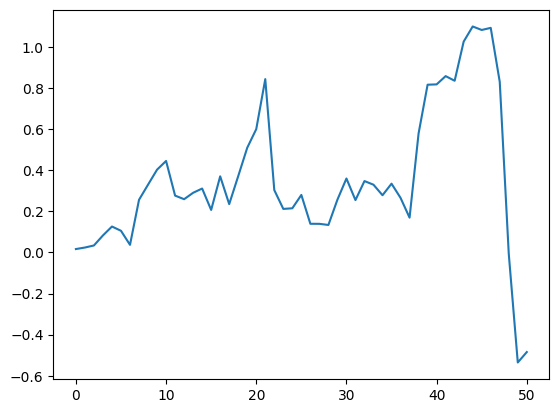

In [17]:
plt.plot(value_list_2)
plt.show()

In [4]:
print(root.game.pieces.copy())

[[14.  0.  0. 16. 15. 13. 12. 14.]
 [11. 11. 11. 13. 11.  0. 11.  0.]
 [ 0.  0. 12. 11.  0. 11.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  1. 11.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  0.  0.  1.]
 [ 4.  2.  3.  6.  5.  3.  0.  4.]]


In [32]:
print(test_board)

test_game = Game()
game.pieces = test_board.copy()
game.FlipBoard()
test_board_2 = game.pieces.copy()
print(test_board_2)

[[ 0. 16.  0.  0.  0. 14.  0.  0.]
 [ 0. 11. 14.  0.  0. 11. 11.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1. 11.  0.  0.  0.  0.  0.  0.]
 [ 0. 12.  0.  0.  0.  0. 12.  2.]
 [ 4.  1.  0.  1. 15.  0.  3.  0.]
 [ 0.  0.  3.  0.  6.  0.  0.  4.]]
[[14.  0.  0. 16.  0. 13.  0.  0.]
 [ 0. 13.  0.  5. 11.  0. 11. 14.]
 [12.  2.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. 11.]
 [ 0.  0.  0. 11.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  4.  1.  0.]
 [ 0.  0.  4.  0.  0.  0.  6.  0.]]


In [33]:
board_tensor = torch.stack([board_to_tensor(test_board_2)])
print(board_tensor.shape)
print(model(board_tensor).detach().numpy())

torch.Size([1, 12, 8, 8])
[[-0.5117809]]


In [5]:
print(root.value)
for c, child in enumerate(root.children):
    # print(child.move, child.visits, root.values_value_indi[c])
    print(child.move, child.value)

[-0.17429683]
((3, 6), (2, 4), 'knight') [0.20158273]
((6, 2), (4, 2), 'pawn double') [0.20725262]
((5, 0), (4, 0), 'pawn') [0.1594004]
((6, 7), (5, 7), 'pawn') [0.17765297]
((6, 3), (5, 3), 'pawn') [0.16457026]
((6, 1), (5, 1), 'pawn') [0.19432324]
((7, 5), (5, 7), 'bishop') [0.21010248]
((6, 2), (5, 2), 'pawn') [0.18175095]
((3, 6), (1, 5), 'knight') [0.18227968]
((6, 5), (4, 5), 'pawn double') [0.22972205]
((3, 6), (5, 5), 'knight') [0.16762033]
((6, 5), (5, 5), 'pawn') [0.2058292]
((7, 0), (6, 0), 'rook') [0.22084834]
((4, 6), (3, 7), 'pawn') [0.16519904]
((7, 1), (5, 2), 'knight') [0.19383875]
((6, 4), (5, 4), 'pawn') [0.16737323]
((6, 1), (4, 1), 'pawn double') [0.1979411]
((3, 6), (5, 7), 'knight') [0.16750029]
((3, 6), (1, 7), 'knight') [0.16713691]
((7, 5), (6, 6), 'bishop') [0.1672442]
((6, 4), (4, 4), 'pawn double') [0.19757417]
((6, 7), (4, 7), 'pawn double') [0.20734109]
((3, 6), (4, 4), 'knight') [0.09983734]
((6, 3), (4, 3), 'pawn double') [0.16863109]
((7, 7), (7, 6), '

In [6]:
boards[-1]

array([[14., 12., 13., 16., 15., 13., 12., 14.],
       [11., 11., 11.,  0., 11., 11., 11., 11.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 11.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 4.,  2.,  3.,  6.,  5.,  3.,  2.,  4.]])

In [5]:
for child in root.children:
    print(child.move)

((6, 7), (4, 7), 'pawn double')
((7, 6), (5, 7), 'knight')
((6, 2), (5, 2), 'pawn')
((7, 6), (5, 5), 'knight')
((7, 1), (5, 0), 'knight')
((6, 3), (4, 3), 'pawn double')
((6, 0), (4, 0), 'pawn double')
((6, 4), (4, 4), 'pawn double')
((6, 7), (5, 7), 'pawn')
((6, 4), (5, 4), 'pawn')
((7, 1), (5, 2), 'knight')
((6, 5), (4, 5), 'pawn double')
((6, 0), (5, 0), 'pawn')
((6, 6), (5, 6), 'pawn')
((6, 2), (4, 2), 'pawn double')
((6, 1), (5, 1), 'pawn')
((6, 5), (5, 5), 'pawn')
((6, 6), (4, 6), 'pawn double')
((6, 1), (4, 1), 'pawn double')
((6, 3), (5, 3), 'pawn')


In [3]:
game = Game()
game.PlayMove(((6, 4), (4, 4), 'pawn double'))
game.FlipBoard()

chosen_move, root = ModelGuided_TS(game, model, root=None, tmax=20, batches=50, prints=False, factor_wins=2, factor_mat=0.0, 
        factor_value_sum=1, factor_value_indi=1, factor_explore=1e-3)

In [13]:
print(root.value)
print(root.game.pieces)
for c, child in enumerate(root.children):
    # print(child.move, child.visits, root.values_value_indi[c])
    # print(child.visits, child.move, child.value, child.matdiff_rollmed.get_median())
    if child.move == ((6, 0), (4, 0), 'pawn double'):
        print(child.game.pieces)
        for c_child, child_child in enumerate(child.children):
            # print(child_child.visits, child_child.move, child_child.matdiff_rollmed.get_median())
            # if child_child.move == ((7, 5), (2, 0), 'bishop'):
            if child_child.move == ((7, 3), (3, 7), 'queen'):
                print(child_child.game.pieces)
    #             print(child_child.value)
                for c_2, child_2 in enumerate(child_child.children):

                    if child_2.move == ((7, 0), (4, 0), 'rook'):
                        
                        print(child_2.game.pieces)

                        for c_3, child_3 in enumerate(child_2.children):


                            # print(child_2.visits, child_2.move, child_2.matdiff_rollmed.get_median())
                            # print(child_child.values_value_sum[c_2])
                            print(child_3.move, child_3.value)

[0.04328359]
[[14. 12. 13. 16. 15. 13. 12. 14.]
 [11. 11. 11.  0. 11. 11. 11. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 11.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 4.  2.  3.  6.  5.  3.  2.  4.]]
[[14. 12. 13. 15. 16. 13. 12. 14.]
 [11. 11. 11. 11. 11. 11. 11.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  1.  1.  1.]
 [ 4.  2.  3.  5.  6.  3.  2.  4.]]
[[14. 12. 13. 16.  0. 13. 12. 14.]
 [11. 11. 11.  0. 11. 11. 11. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 11.  0.  0.  0.  0.]
 [15.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.]
 [ 4.  2.  3.  6.  5.  3.  2.  4.]]
[[14. 12. 13. 15. 16. 13. 12.  0.]
 [11. 11. 11. 11. 11. 11. 11.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 14.]
 [ 0

In [7]:
print(root.value)
print(root.game.pieces)
for c, child in enumerate(root.children):
    # print(child.move, child.visits, root.values_value_indi[c])
    # print(child.visits, child.move, child.value, root.values_mat[c])
    if child.move == ((6, 2), (4, 2), 'pawn double'):
        print(child.game.pieces)
        print(child.move, child.visits, root.values_mat[c])

        print('mat value blocks: ')
        print(child.matdiff_sum)
        print(child.matdiff_sum / max(child.visits, 1))
        print(root.matdiff_sum)
        print(root.matdiff_sum / max(root.visits, 1))

        # [np.tanh(child.matdiff_sum / max(child.visits, 1) + self.matdiff_sum / max(self.visits, 1))    
        #                 for child in self.children]

        for c_child, child_child in enumerate(child.children):
            # print(child_child.visits, child_child.move, child_child.value, child.values_mat[c_child])
            print(child_child.move, child_child.visits, child_child.matdiff_sum)
    #         if child_child.move == ((7, 5), (2, 0), 'bishop'):
    #             print(child_child.game.pieces)
    #             print(child_child.value)
    #             for c_2, child_2 in enumerate(child_child.children):
    #                 print(child_2.visits, child_2.move, child_2.value)

[0.04328359]
[[14. 12. 13. 16. 15. 13. 12. 14.]
 [11. 11. 11.  0. 11. 11. 11. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 11.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 4.  2.  3.  6.  5.  3.  2.  4.]]
[[14. 12. 13. 15. 16. 13. 12. 14.]
 [11. 11. 11. 11. 11.  0. 11. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 11.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  1.  1.  1.]
 [ 4.  2.  3.  5.  6.  3.  2.  4.]]
((6, 2), (4, 2), 'pawn double') 310 0.22204529527837974
mat value blocks: 
70
0.22580645161290322
-16962
-1.3156996587030716
((7, 3), (4, 6), 'queen') 2 0
((7, 4), (6, 4), 'king') 1 0
((6, 2), (4, 2), 'pawn double') 2 0
((7, 5), (4, 2), 'bishop') 1 0
((6, 1), (5, 1), 'pawn') 1 0
((6, 6), (4, 6), 'pawn double') 2 0
((6, 3), (4, 3), 'pawn double') 1 0
((7, 5), (2, 0), 'bishop') 66 -21
((6, 0), (4, 0), 'pawn double') 2 0
((4

In [22]:
g_test = Game()
print(g_test.pieces)
g_test.PlayMove(((6, 5), (5, 5), 'pawn'))
g_test.FlipBoard()
print(g_test.pieces)
g_test.PlayMove(((6, 3), (5, 3), 'pawn'))
g_test.FlipBoard()
print(g_test.pieces)
g_test.PlayMove(((6, 6), (4, 6), 'pawn double'))
g_test.FlipBoard()
print(g_test.pieces)
g_test.PlayMove(((7, 4), (3, 0), 'queen'))

print(g_test.pieces)

board_tensor = torch.stack([board_to_tensor(g_test.pieces)])
print(model(board_tensor).detach().numpy())



[[14 12 13 15 16 13 12 14]
 [11 11 11 11 11 11 11 11]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1]
 [ 4  2  3  5  6  3  2  4]]
[[14. 12. 13. 16. 15. 13. 12. 14.]
 [11. 11.  0. 11. 11. 11. 11. 11.]
 [ 0.  0. 11.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 4.  2.  3.  6.  5.  3.  2.  4.]]
[[14. 12. 13. 15. 16. 13. 12. 14.]
 [11. 11. 11. 11.  0. 11. 11. 11.]
 [ 0.  0.  0.  0. 11.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  1.  1.  1.  1.  0.  1.  1.]
 [ 4.  2.  3.  5.  6.  3.  2.  4.]]
[[14. 12. 13. 16. 15. 13. 12. 14.]
 [11.  0.  0. 11. 11. 11. 11. 11.]
 [ 0.  0. 11.  0.  0.  0.  0.  0.]
 [ 0. 11.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  1.  

In [64]:
test_board= np.array(
[[14., 0. ,13., 16. ,15. ,13.,12. ,14.],
 [11. ,11. ,11. ,0. ,11. ,11., 11., 11.],
 [ 0. , 0. , 12. , 0. , 0. ,0. , 0. , 0.],
 [ 0. , 0. , 0. , 11. , 0. ,0. , 0. , 0.],
 [ 0. , 5. , 0. , 1. , 0. , 0. , 0., 0.],
 [ 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.],
 [ 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1.],
 [ 4. , 2. , 3. , 6. , 0. , 3. , 2. , 4.]])


board_tensor = torch.stack([board_to_tensor(test_board)])
print(model(board_tensor).detach().numpy())

[[0.08739713]]
